## Goal
Write a neural network that can:
- take 2 inputs:
  - an image from MNIST dataset, and
  - a random number between 0 and 9
- and gives two outputs:
  - the "number" that was represented by the MNIST image, and
  - the "sum" of this number with the random number that was generated and sent as the input to the network
  

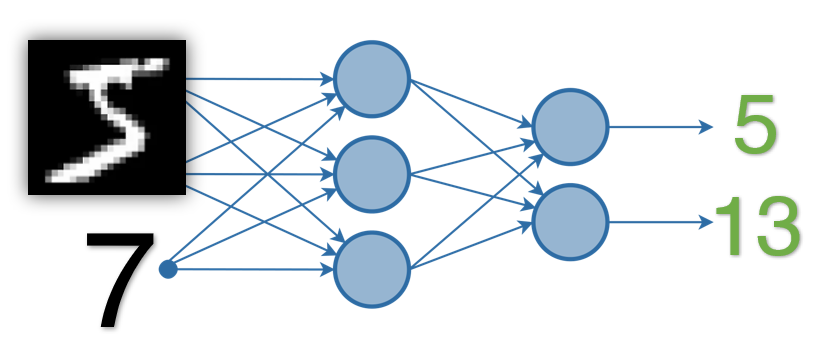

In [52]:
import torch
import torchvision
import torchvision.transforms as transforms

In [53]:
# getting train/test MNIST dataset

train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

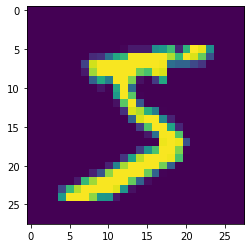

random:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
mnist_label:  5
sum_label:  7


In [63]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

# create an enhanced MNIST dataset class which adds the information about "random" numbers to the input and the output of each image
class EnhancedMNIST():
  def __init__(self, dataset):
    self.dataset = dataset
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    randnum = random.randint(0, 9)
    rand = F.one_hot(torch.tensor(randnum), num_classes=10)
    sum_label = label+randnum

    return {"image": image, "rand": rand, "mnist_label": label, "sum_label": sum_label}

new_train_set = EnhancedMNIST(train_set)
new_test_set = EnhancedMNIST(test_set)

# sanity check
sample = new_train_set[0]
plt.imshow(sample['image'][0])
plt.show()
print("random: ", sample['rand'])
print("mnist_label: ", sample['mnist_label'])
print("sum_label: ", sample['sum_label'])


In [55]:
# next we get our dataloaders from our enhanced MNIST dataset
train_loader = torch.utils.data.DataLoader(new_train_set
    ,batch_size=128
    ,shuffle=True
)
test_loader = torch.utils.data.DataLoader(new_test_set
    ,batch_size=128
    ,shuffle=True
)

# sanity check
next(iter(train_loader))['image'].shape

torch.Size([128, 1, 28, 28])

In [56]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super().__init__()

    # conv and pool layers copied from other assignment
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)      # 1x28x28    -->  32x28x28 
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)     # 32x28x28   -->  64x28x28 
    self.pool1 = nn.MaxPool2d(2, 2)                  # 64x28x28   -->  64x14x14 
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)    # 64x14x14   -->  128x14x14
    self.conv4 = nn.Conv2d(128, 256, 3, padding=1)   # 128x14x14  -->  256x14x14
    self.pool2 = nn.MaxPool2d(2, 2)                  # 256x14x14  -->  256x7x7  
    self.conv5 = nn.Conv2d(256, 512, 3)              # 256x7x7    -->  512x5x5  
    self.conv6 = nn.Conv2d(512, 1024, 3)             # 512x5x5    -->  1024x3x3 
    self.conv7 = nn.Conv2d(1024, 10, 3)              # 1024x3x3   -->  10x1x1

    # These layers will take in two (concatenated) One Hot Vectors of mnist prediction and the random number and try to add them together
    self.fc1 = nn.Linear(in_features=20, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=20)
  
  def forward(self, x):
    # send each of these to device, since dict can't be sent to gpu
    rand = x['rand'].to(device)
    x = x['image'].to(device)

    # get the mnist prediction
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
    x = F.relu(self.conv6(F.relu(self.conv5(x))))
    x = self.conv7(x)
    x = x.view(-1, 10)
    mnist_pred = F.log_softmax(x, dim=1)

    # concatenate mnist pred to the one_hot_vector of the random number
    x = torch.cat((mnist_pred, rand), dim=1)

    # run this through the two fc layers and get prediction
    x = F.relu(self.fc1(x))
    x = F.log_softmax(self.fc2(x), dim=1)
    return {"mnist_pred": mnist_pred, "sum_pred": x}

net = Net().to(device)

# sanity check
print(net(next(iter(train_loader)))['mnist_pred'].shape)
net(next(iter(train_loader)))['sum_pred'].shape

torch.Size([128, 10])


torch.Size([128, 20])

In [57]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [156]:
from tqdm.notebook import tqdm # the CORRECT way to use tqdm in a notebook

torch.set_grad_enabled(True)

net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters())

# function to get accuracy from preds one_hot_vector and target (not one_hot_vector)
def get_accuracy(preds, target):
  preds = torch.argmax(preds, dim=1)
  assert len(preds)==len(target), "preds length not equal to target length"
  
  count=0
  for i in range(len(preds)):
    if preds[i]==target[i]:
      count+=1
  return count/len(preds)

# accumulate history for training graph
total_loss = {'mnist': [], 'sum': []}
total_acc = {'mnist': [], 'sum': []}

for epoch in range(5):
  epoch_loss = {'mnist': [], 'sum': []}
  epoch_acc = {'mnist': [], 'sum': []}

  for idx, batch in enumerate(tqdm(train_loader, leave=False)):
    preds = net(batch)

    # get labels and preds
    mnist_labels = batch['mnist_label']
    sum_labels = batch['sum_label']
    mnist_preds = preds['mnist_pred'].cpu()
    sum_preds = preds['sum_pred'].cpu()

    # get loss using cross entropy (because it's multiclass)
    mnist_loss = F.cross_entropy(mnist_preds, mnist_labels)
    sum_loss = F.cross_entropy(sum_preds, sum_labels)
    mnist_acc = get_accuracy(mnist_preds, mnist_labels)
    sum_acc = get_accuracy(sum_preds, sum_labels)

    # to have good accuracy for the sum, we first need to have good accuracy for the mnist task
    # if the batch accuracy for mnist < 50%, train mnist
    # if batch accuracy for mnist is between 50% and 95%, randomly train one of them
    # if batch accuracy for mnist > 95, train the fc layers for sum calculation
    # due to random variations in batch accuracy, in some batches, mnist will train even if average epoch accuracy > 90%
    optimizer.zero_grad()

    if (mnist_acc<0.5):
      mnist_loss.backward()
    elif (0.95>mnist_acc>0.5):
      mnist_loss.backward() if idx%2==0 else sum_loss.backward()
    else:
      sum_loss.backward()
    
    optimizer.step()

    # add total loss and total correct
    epoch_loss['mnist'].append(mnist_loss.item())
    epoch_loss['sum'].append(sum_loss.item())
    epoch_acc['mnist'].append(mnist_acc)
    epoch_acc['sum'].append(sum_acc)
  
  # write stats every epoch
  total_loss['mnist'].extend(epoch_loss['mnist'])
  total_loss['sum'].extend(epoch_loss['sum'])
  total_acc['mnist'].extend(epoch_acc['mnist'])
  total_acc['sum'].extend(epoch_acc['sum'])
  
  epoch_avg_acc = {'mnist': round(100*sum(epoch_acc['mnist'])/len(epoch_acc['mnist']), 2), 
                    'sum': round(100*sum(epoch_acc['sum'])/len(epoch_acc['sum']), 2)}
  epoch_avg_loss = {'mnist': round(sum(epoch_loss['mnist'])/len(epoch_loss['mnist']), 4), 
                    'sum': round(sum(epoch_acc['sum'])/len(epoch_acc['sum']), 4)}

  epoch_avg_loss['total'] = round(epoch_avg_loss['mnist']+epoch_avg_loss['sum'], 4)
  epoch_avg_acc['total'] = round(0.5*(epoch_avg_acc['mnist']+epoch_avg_acc['sum']), 2)

  print(f"--EPOCH {epoch+1}:")
  print(f"Loss:     \t MNIST: {epoch_avg_loss['mnist']} \t SUM: {epoch_avg_loss['sum']} \t TOTAL: {epoch_avg_loss['total']}")
  print(f"Accuracy: \t MNIST: %{epoch_avg_acc['mnist']} \t SUM: %{epoch_avg_acc['sum']} \t TOTAL: %{epoch_avg_acc['total']}")


--EPOCH 1:
Loss:     	 MNIST: 0.2404 	 SUM: 0.1889 	 TOTAL: 0.4293
Accuracy: 	 MNIST: %93.14 	 SUM: %18.89 	 TOTAL: %56.02


--EPOCH 2:
Loss:     	 MNIST: 0.1103 	 SUM: 0.6486 	 TOTAL: 0.7589
Accuracy: 	 MNIST: %98.03 	 SUM: %64.86 	 TOTAL: %81.44


--EPOCH 3:
Loss:     	 MNIST: 0.0657 	 SUM: 0.9541 	 TOTAL: 1.0198
Accuracy: 	 MNIST: %98.83 	 SUM: %95.41 	 TOTAL: %97.12


--EPOCH 4:
Loss:     	 MNIST: 0.0461 	 SUM: 0.9888 	 TOTAL: 1.0349
Accuracy: 	 MNIST: %99.11 	 SUM: %98.88 	 TOTAL: %99.0


--EPOCH 5:
Loss:     	 MNIST: 0.0388 	 SUM: 0.9932 	 TOTAL: 1.032
Accuracy: 	 MNIST: %99.3 	 SUM: %99.32 	 TOTAL: %99.31


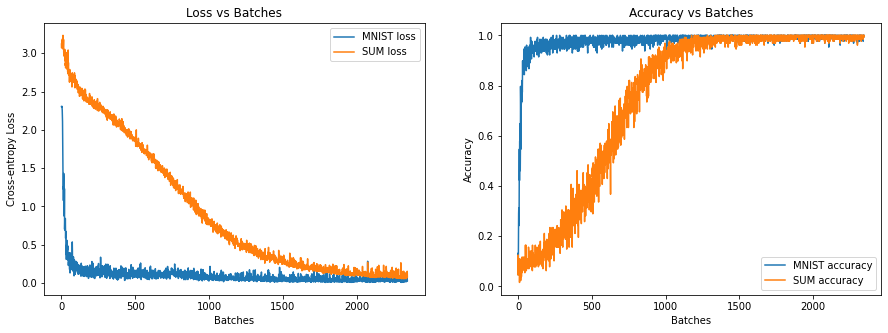

In [157]:
# generate training graphs
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figwidth(15)
fig.set_figheight(5)

ax1.plot(total_loss['mnist'], label="MNIST loss")
ax1.plot(total_loss['sum'], label="SUM loss")
ax1.legend()
ax1.set_title("Loss vs Batches")
ax1.set_xlabel("Batches")
ax1.set_ylabel("Cross-entropy Loss")

ax2.plot(total_acc['mnist'], label="MNIST accuracy")
ax2.plot(total_acc['sum'], label="SUM accuracy")
ax2.legend()
ax2.set_title("Accuracy vs Batches")
ax2.set_xlabel("Batches")
ax2.set_ylabel("Accuracy")

plt.show()

In [158]:
# evaluate with test loader
torch.set_grad_enabled(False)

test_losses = {'mnist': [], 'sum': []}
test_accs = {'mnist': [], 'sum': []}

for idx, batch in enumerate(tqdm(train_loader, leave=False)):
  preds = net(batch)

  # get labels and preds
  mnist_labels = batch['mnist_label']
  sum_labels = batch['sum_label']
  mnist_preds = preds['mnist_pred'].cpu()
  sum_preds = preds['sum_pred'].cpu()

  # get loss using cross entropy (because it's multiclass)
  mnist_loss = F.cross_entropy(mnist_preds, mnist_labels)
  sum_loss = F.cross_entropy(sum_preds, sum_labels)
  mnist_acc = get_accuracy(mnist_preds, mnist_labels)
  sum_acc = get_accuracy(sum_preds, sum_labels)

  # add total loss and total correct
  test_losses['mnist'].append(mnist_loss.item())
  test_losses['sum'].append(sum_loss.item())
  test_accs['mnist'].append(mnist_acc)
  test_accs['sum'].append(sum_acc)
  
  
final_avg_acc = {'mnist': round(100*sum(test_accs['mnist'])/len(test_accs['mnist']), 2), 
                    'sum': round(100*sum(test_accs['sum'])/len(test_accs['sum']), 2)}
final_avg_loss = {'mnist': round(sum(test_losses['mnist'])/len(test_losses['mnist']), 4), 
                    'sum': round(sum(test_accs['sum'])/len(test_accs['sum']), 4)}

final_avg_loss['total'] = round(final_avg_loss['mnist']+final_avg_loss['sum'], 4)
final_avg_acc['total'] = round(0.5*(final_avg_acc['mnist']+final_avg_acc['sum']), 2)

print(f"--TEST results")
print(f"Loss:     \t MNIST: {final_avg_loss['mnist']} \t SUM: {final_avg_loss['sum']} \t TOTAL: {final_avg_loss['total']}")
print(f"Accuracy: \t MNIST: %{final_avg_acc['mnist']} \t SUM: %{final_avg_acc['sum']} \t TOTAL: %{final_avg_acc['total']}")

--TEST results
Loss:     	 MNIST: 0.0316 	 SUM: 0.9954 	 TOTAL: 1.027
Accuracy: 	 MNIST: %99.51 	 SUM: %99.54 	 TOTAL: %99.53


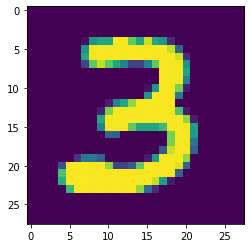

MNIST target: 3
Random target: 1
Sum target: 4

MNIST prediction: 3
Sum prediction: 4


In [159]:
# Running sample test data through the network
sample = next(iter(test_loader))
preds = net(sample)
plt.imshow(sample['image'][0].squeeze())
plt.show()
print(f"MNIST target: {sample['mnist_label'][0]}")
print(f"Random target: {torch.argmax(sample['rand'][0])}")
print(f"Sum target: {sample['sum_label'][0]}\n")
print(f"MNIST prediction: {torch.argmax(preds['mnist_pred'][0])}")
print(f"Sum prediction: {torch.argmax(preds['sum_pred'][0])}")